In [1]:
# !pip install optuna

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import joblib
import pickle
import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
with open('crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)


data = data[['date', 'trade_price']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date').reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['trade_price']

# 예측 데이터 사이즈
max_prediction_length = 20

# 학습용 데이터
data_p = data.iloc[:data.index.max() - max_prediction_length +1, :]
training_data = scaler.fit_transform(data_p[scale_cols])

# max_prediction_length 만큼의 데이터는 예측 데이터와 비교를 위해 분리
actual_data = data.loc[~data.index.isin(data_p.index)][scale_cols]




In [4]:
def sliding_windows(data, lookback_length, forecast_length):

    x = []
    y = []
    
    for i in range(lookback_length, len(data) - forecast_length + 1):
        _x = data[(i-lookback_length) : i]
        _y = data[i : (i + forecast_length)]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def get_data_loader(X, y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    train_ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    train_dl = DataLoader(train_ds, batch_size = batch_size)

    val_ds = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
    val_dl = DataLoader(val_ds, batch_size = batch_size)

    input_size = x_train.shape[-1]

    return train_dl, val_dl, input_size

In [5]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size , num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [6]:
def train(log_interval, model, train_dl, val_dl, optimizer, criterion, epoch):

    best_loss = np.inf
    for epoch in range(epoch):
        train_loss = 0.0
        model.train()
        for data, target in train_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                model = model.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) # mean-squared error for regression
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation
        valid_loss = 0.0
        model.eval()
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = model(data)         
            loss = criterion(output, target)
            valid_loss += loss.item()

        if ( epoch % log_interval == 0 ):
            print(f'\n Epoch {epoch} \t Training Loss: {train_loss / len(train_dl)} \t Validation Loss: {valid_loss / len(val_dl)} \n')

        if best_loss > (valid_loss / len(val_dl)):
            print(f'Validation Loss Decreased({best_loss:.6f}--->{(valid_loss / len(val_dl)):.6f}) \t Saving The Model')
            best_loss = (valid_loss / len(val_dl))
            torch.save(model.state_dict(), 'lstm_saved_model.pth')

    return best_loss


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [38]:
def objective(trial):
    num_epochs = 10
    cfg = {
            'batch_size' : trial.suggest_categorical('batch_size',[64, 128, 256]), # [64, 128, 256]
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), #trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), # learning rate을 0.01-0.1까지 로그 uniform 분포로 사용          
            'momentum': trial.suggest_uniform('momentum', 0.4, 0.99),
            'optimizer': trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]), # trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]),
            # 'activation': trial.suggest_categorical('activation',[ torch.nn.relu6, torch.nn.tanh ]),
            'hidden_size': trial.suggest_categorical('hidden_size',[64, 128, 256]),
            'num_layers': trial.suggest_int('num_layers', 1, 1),
    }

    torch.manual_seed(42)

    lookback_length = 60
    forecast_length = 1
    log_interval = 100

    x, y = sliding_windows(training_data, lookback_length, forecast_length)

    train_dl, val_dl, input_size = get_data_loader(x, y,  cfg['batch_size'])
    model = LSTM(num_classes = 1, input_size=input_size, hidden_size=cfg['hidden_size'], num_layers=cfg['num_layers'])

    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['learning_rate'])
    criterion = torch.nn.MSELoss()

    if torch.cuda.is_available():
        model = model.cuda()

    best_loss = train(log_interval, model, train_dl, val_dl, optimizer, criterion, num_epochs)

    predict_data = []

    x_pred = x[-1:, :, :]  # last observed input sequence
    y_pred = y[-1]         # last observed target value

    for i in range(max_prediction_length):
        # feed the last forecast back to the model as an input
        x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)
        xt_pred = torch.Tensor(x_pred)
        if torch.cuda.is_available():
            xt_pred = xt_pred.cuda()

        # generate the next forecast
        yt_pred = model(xt_pred)

        # tensor to array
        x_pred = xt_pred.cpu().detach().numpy()
        y_pred = yt_pred.cpu().detach().numpy()

        # save the forecast
        predict_data.append(y_pred.flatten()[0])

    # transform the forecasts back to the original scale
    predict_data = np.array(predict_data).reshape(-1, 1)
    predict = scaler.inverse_transform(predict_data)

    actual = np.array(actual_data)

    SMAPE = smape(actual, predict)
    print(f' \nSMAPE : {SMAPE}')


    return SMAPE


In [39]:
sampler = optuna.samplers.TPESampler()
#   sampler = optuna.samplers.SkoptSampler()

# model.load_state_dict(torch.load('lstm_saved_model.pth'))
    
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=10)

[I 2022-06-15 05:15:54,491] A new study created in memory with name: no-name-528c330c-87ca-46f2-810b-3ab885c79c34



 Epoch 0 	 Training Loss: 104.11152311139519 	 Validation Loss: 808.8887939453125 

Validation Loss Decreased(inf--->808.888794) 	 Saving The Model
Validation Loss Decreased(808.888794--->55.245209) 	 Saving The Model
Validation Loss Decreased(55.245209--->1.421950) 	 Saving The Model
Validation Loss Decreased(1.421950--->0.157032) 	 Saving The Model


[I 2022-06-15 05:15:55,814] Trial 0 finished with value: 102.87388873925461 and parameters: {'batch_size': 64, 'num_epochs': 100, 'learning_rate': 0.031727915880274474, 'momentum': 0.6347947794539429, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 256, 'num_layers': 1}. Best is trial 0 with value: 102.87388873925461.


 
SMAPE : 102.87388873925461

 Epoch 0 	 Training Loss: 0.020209499919734038 	 Validation Loss: 0.789522777001063 

Validation Loss Decreased(inf--->0.789523) 	 Saving The Model
Validation Loss Decreased(0.789523--->0.342262) 	 Saving The Model
Validation Loss Decreased(0.342262--->0.326640) 	 Saving The Model
Validation Loss Decreased(0.326640--->0.268652) 	 Saving The Model
Validation Loss Decreased(0.268652--->0.184402) 	 Saving The Model
Validation Loss Decreased(0.184402--->0.037440) 	 Saving The Model


[I 2022-06-15 05:15:57,051] Trial 1 finished with value: 26.093473306630308 and parameters: {'batch_size': 64, 'num_epochs': 100, 'learning_rate': 0.011359607358447, 'momentum': 0.5985819836909885, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 128, 'num_layers': 1}. Best is trial 1 with value: 26.093473306630308.


Validation Loss Decreased(0.037440--->0.015060) 	 Saving The Model
 
SMAPE : 26.093473306630308

 Epoch 0 	 Training Loss: 16.21123648909005 	 Validation Loss: 65.55919392903645 

Validation Loss Decreased(inf--->65.559194) 	 Saving The Model
Validation Loss Decreased(65.559194--->0.207415) 	 Saving The Model
Validation Loss Decreased(0.207415--->0.077446) 	 Saving The Model


[I 2022-06-15 05:15:58,002] Trial 2 finished with value: 128.0435203488481 and parameters: {'batch_size': 128, 'num_epochs': 100, 'learning_rate': 0.041288395268989794, 'momentum': 0.8482961756701076, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 256, 'num_layers': 1}. Best is trial 1 with value: 26.093473306630308.


 
SMAPE : 128.0435203488481

 Epoch 0 	 Training Loss: 0.02953344817135737 	 Validation Loss: 0.20674488445123038 

Validation Loss Decreased(inf--->0.206745) 	 Saving The Model
Validation Loss Decreased(0.206745--->0.195163) 	 Saving The Model
Validation Loss Decreased(0.195163--->0.191095) 	 Saving The Model
Validation Loss Decreased(0.191095--->0.187459) 	 Saving The Model
Validation Loss Decreased(0.187459--->0.183815) 	 Saving The Model
Validation Loss Decreased(0.183815--->0.180131) 	 Saving The Model
Validation Loss Decreased(0.180131--->0.176400) 	 Saving The Model
Validation Loss Decreased(0.176400--->0.172616) 	 Saving The Model
Validation Loss Decreased(0.172616--->0.168776) 	 Saving The Model


[I 2022-06-15 05:15:58,714] Trial 3 finished with value: 56.884911560527726 and parameters: {'batch_size': 128, 'num_epochs': 100, 'learning_rate': 0.0804265568016452, 'momentum': 0.8794245662151807, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 64, 'num_layers': 1}. Best is trial 1 with value: 26.093473306630308.


Validation Loss Decreased(0.168776--->0.164877) 	 Saving The Model
 
SMAPE : 56.884911560527726

 Epoch 0 	 Training Loss: 0.0715517964369307 	 Validation Loss: 0.4255833625793457 

Validation Loss Decreased(inf--->0.425583) 	 Saving The Model
Validation Loss Decreased(0.425583--->0.375129) 	 Saving The Model
Validation Loss Decreased(0.375129--->0.339448) 	 Saving The Model
Validation Loss Decreased(0.339448--->0.313847) 	 Saving The Model
Validation Loss Decreased(0.313847--->0.295247) 	 Saving The Model
Validation Loss Decreased(0.295247--->0.281581) 	 Saving The Model


[I 2022-06-15 05:15:59,254] Trial 4 finished with value: 87.07071114470051 and parameters: {'batch_size': 256, 'num_epochs': 100, 'learning_rate': 0.01720305347181075, 'momentum': 0.7953049898181068, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 128, 'num_layers': 1}. Best is trial 1 with value: 26.093473306630308.


Validation Loss Decreased(0.281581--->0.271437) 	 Saving The Model
Validation Loss Decreased(0.271437--->0.263829) 	 Saving The Model
Validation Loss Decreased(0.263829--->0.258063) 	 Saving The Model
Validation Loss Decreased(0.258063--->0.253643) 	 Saving The Model
 
SMAPE : 87.07071114470051

 Epoch 0 	 Training Loss: 0.9846097719134941 	 Validation Loss: 0.0394421451104184 

Validation Loss Decreased(inf--->0.039442) 	 Saving The Model
Validation Loss Decreased(0.039442--->0.033631) 	 Saving The Model
Validation Loss Decreased(0.033631--->0.027812) 	 Saving The Model


[I 2022-06-15 05:16:00,596] Trial 5 finished with value: 20.45931968127725 and parameters: {'batch_size': 64, 'num_epochs': 100, 'learning_rate': 0.03275618244982927, 'momentum': 0.6432695392348664, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 128, 'num_layers': 1}. Best is trial 5 with value: 20.45931968127725.


Validation Loss Decreased(0.027812--->0.024886) 	 Saving The Model
 
SMAPE : 20.45931968127725

 Epoch 0 	 Training Loss: 1.7310977672089145 	 Validation Loss: 0.7308930357297262 

Validation Loss Decreased(inf--->0.730893) 	 Saving The Model
Validation Loss Decreased(0.730893--->0.682354) 	 Saving The Model
Validation Loss Decreased(0.682354--->0.031513) 	 Saving The Model


[I 2022-06-15 05:16:01,367] Trial 6 finished with value: 55.03594558979699 and parameters: {'batch_size': 128, 'num_epochs': 100, 'learning_rate': 0.03190910906955249, 'momentum': 0.6589331215111673, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 128, 'num_layers': 1}. Best is trial 5 with value: 20.45931968127725.


 
SMAPE : 55.03594558979699

 Epoch 0 	 Training Loss: 0.07443055084634882 	 Validation Loss: 0.32758675515651703 

Validation Loss Decreased(inf--->0.327587) 	 Saving The Model
Validation Loss Decreased(0.327587--->0.204748) 	 Saving The Model
Validation Loss Decreased(0.204748--->0.163053) 	 Saving The Model
Validation Loss Decreased(0.163053--->0.079230) 	 Saving The Model


[I 2022-06-15 05:16:01,846] Trial 7 finished with value: 96.67383675251517 and parameters: {'batch_size': 256, 'num_epochs': 100, 'learning_rate': 0.015222660281179462, 'momentum': 0.41881760264208867, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 64, 'num_layers': 1}. Best is trial 5 with value: 20.45931968127725.


 
SMAPE : 96.67383675251517

 Epoch 0 	 Training Loss: 0.02701628790150391 	 Validation Loss: 0.24959138532479605 

Validation Loss Decreased(inf--->0.249591) 	 Saving The Model
Validation Loss Decreased(0.249591--->0.231944) 	 Saving The Model
Validation Loss Decreased(0.231944--->0.227179) 	 Saving The Model
Validation Loss Decreased(0.227179--->0.223262) 	 Saving The Model
Validation Loss Decreased(0.223262--->0.219399) 	 Saving The Model
Validation Loss Decreased(0.219399--->0.215532) 	 Saving The Model
Validation Loss Decreased(0.215532--->0.211651) 	 Saving The Model
Validation Loss Decreased(0.211651--->0.207750) 	 Saving The Model
Validation Loss Decreased(0.207750--->0.203823) 	 Saving The Model


[I 2022-06-15 05:16:03,047] Trial 8 finished with value: 71.13678333934286 and parameters: {'batch_size': 64, 'num_epochs': 100, 'learning_rate': 0.043718860467481066, 'momentum': 0.8722034244420296, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 128, 'num_layers': 1}. Best is trial 5 with value: 20.45931968127725.


Validation Loss Decreased(0.203823--->0.199867) 	 Saving The Model
 
SMAPE : 71.13678333934286

 Epoch 0 	 Training Loss: 0.046419447365527354 	 Validation Loss: 0.31567811965942383 

Validation Loss Decreased(inf--->0.315678) 	 Saving The Model
Validation Loss Decreased(0.315678--->0.291316) 	 Saving The Model
Validation Loss Decreased(0.291316--->0.274364) 	 Saving The Model
Validation Loss Decreased(0.274364--->0.262391) 	 Saving The Model
Validation Loss Decreased(0.262391--->0.253817) 	 Saving The Model
Validation Loss Decreased(0.253817--->0.247589) 	 Saving The Model
Validation Loss Decreased(0.247589--->0.242995) 	 Saving The Model
Validation Loss Decreased(0.242995--->0.239546) 	 Saving The Model


[I 2022-06-15 05:16:03,541] Trial 9 finished with value: 82.98727714396942 and parameters: {'batch_size': 256, 'num_epochs': 100, 'learning_rate': 0.019739894436545107, 'momentum': 0.5950082285863193, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 64, 'num_layers': 1}. Best is trial 5 with value: 20.45931968127725.


Validation Loss Decreased(0.239546--->0.236905) 	 Saving The Model
Validation Loss Decreased(0.236905--->0.234833) 	 Saving The Model
 
SMAPE : 82.98727714396942


In [ ]:
# joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_220612_01.pkl')
# joblib.dump(study, '/content/lstm_optuna.pkl')

Number of finished trials:  10
Best trial:
  Value:  20.45931968127725
  Params: 
    batch_size: 64
    num_epochs: 100
    learning_rate: 0.03275618244982927
    momentum: 0.6432695392348664
    optimizer: <class 'torch.optim.adam.Adam'>
    hidden_size: 128
    num_layers: 1


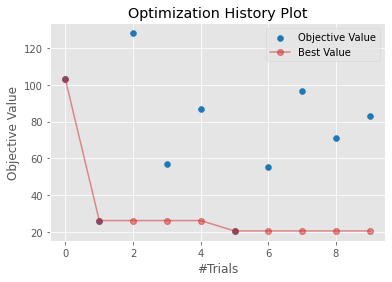

In [40]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.show()


optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

## Plot Results


 Epoch 0 	 Training Loss: 0.9846097719134941 	 Validation Loss: 0.0394421451104184 

Validation Loss Decreased(inf--->0.039442) 	 Saving The Model
Validation Loss Decreased(0.039442--->0.033631) 	 Saving The Model
Validation Loss Decreased(0.033631--->0.027812) 	 Saving The Model
Validation Loss Decreased(0.027812--->0.024886) 	 Saving The Model
Validation Loss Decreased(0.024886--->0.019918) 	 Saving The Model
Validation Loss Decreased(0.019918--->0.017348) 	 Saving The Model
Validation Loss Decreased(0.017348--->0.016148) 	 Saving The Model
Validation Loss Decreased(0.016148--->0.015830) 	 Saving The Model
Validation Loss Decreased(0.015830--->0.015361) 	 Saving The Model
Validation Loss Decreased(0.015361--->0.014916) 	 Saving The Model
Validation Loss Decreased(0.014916--->0.014506) 	 Saving The Model
Validation Loss Decreased(0.014506--->0.014114) 	 Saving The Model
Validation Loss Decreased(0.014114--->0.013723) 	 Saving The Model
Validation Loss Decreased(0.013723--->0.013342) 

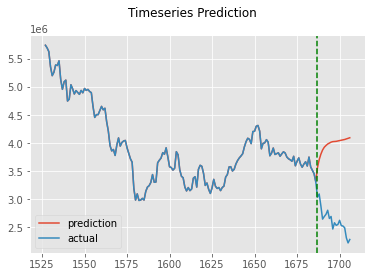

In [41]:
torch.manual_seed(42)

lookback_length = 60
forecast_length = 1
log_interval = 100

x, y = sliding_windows(training_data, lookback_length, forecast_length)

train_dl, val_dl, input_size = get_data_loader(x, y,  study.best_params['batch_size'])
best_model = LSTM(num_classes=1, input_size=input_size, hidden_size=study.best_params['hidden_size'], num_layers=study.best_params['num_layers'])
optimizer = study.best_params['optimizer'](best_model.parameters(), lr=study.best_params['learning_rate'])
criterion = torch.nn.MSELoss()

best_loss = train(log_interval, best_model, train_dl, val_dl, optimizer, criterion, study.best_params['num_epochs'])

predict_data = []

x_pred = x[-1:, :, :]  # last observed input sequence
y_pred = y[-1]         # last observed target value

for i in range(max_prediction_length):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    xt_pred = torch.Tensor(x_pred)

    if torch.cuda.is_available:
        xt_pred = xt_pred.cuda()
        
    # generate the next forecast
    yt_pred = best_model(xt_pred)

    # tensor to array
    x_pred = xt_pred.cpu().detach().numpy()
    y_pred = yt_pred.cpu().detach().numpy()

    # save the forecast
    predict_data.append(y_pred.flatten()[0])

# transform the forecasts back to the original scale
predict_data = np.array(predict_data).reshape(-1, 1)
predict = scaler.inverse_transform(predict_data)

actual = np.array(actual_data)

SMAPE = smape(actual, predict)
print(f' \nSMAPE : {SMAPE}')

# torch.save(best_model.state_dict(), "lstm.pt")


pred_df = pd.concat([data_p[scale_cols], pd.DataFrame(predict, columns=['trade_price'])], axis=0).reset_index(drop=True)
pred_df = pred_df.rename(columns = {'trade_price':'pred_price'})
data_df = pd.concat([data, pred_df], axis=1)

plt.plot(data_df['pred_price'][len(data_df)-lookback_length*3:], label='prediction')
plt.plot(data_df['trade_price'][len(data_df)-lookback_length*3:], label='actual')
plt.suptitle('Timeseries Prediction')
plt.suptitle('Timeseries Prediction')
plt.axvline(x = len(data_df) - len(predict), c = 'g', linestyle = '--')
plt.legend()
plt.show();


ZeroDivisionError: Weights sum to zero, can't be normalized

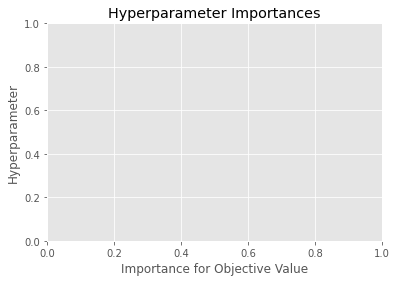

In [42]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()
# df_plot = df_plot[df_plot['value']!=0]

In [29]:

def objective(trial):
    x = trial.suggest_float("x", 0, 5)
    y = trial.suggest_float("y", 1, 1)

    v0 = 4 * x ** 2 + 4 * y ** 2
    
    return v0


study = optuna.create_study()
study.optimize(objective, n_trials=10)
fig = optuna.visualization.plot_param_importances(study)


[I 2022-06-15 05:04:40,134] A new study created in memory with name: no-name-10acb743-77fb-4305-a9bd-ebbc033d8b29
[I 2022-06-15 05:04:40,136] Trial 0 finished with value: 4.981217848300079 and parameters: {'x': 0.49528220448045557, 'y': 1.0}. Best is trial 0 with value: 4.981217848300079.
[I 2022-06-15 05:04:40,138] Trial 1 finished with value: 36.881755645926205 and parameters: {'x': 2.8671307803240422, 'y': 1.0}. Best is trial 0 with value: 4.981217848300079.
[I 2022-06-15 05:04:40,139] Trial 2 finished with value: 5.109005151343094 and parameters: {'x': 0.5265465675852171, 'y': 1.0}. Best is trial 0 with value: 4.981217848300079.
[I 2022-06-15 05:04:40,141] Trial 3 finished with value: 20.595572277694917 and parameters: {'x': 2.0368831752026746, 'y': 1.0}. Best is trial 0 with value: 4.981217848300079.
[I 2022-06-15 05:04:40,142] Trial 4 finished with value: 45.04969908942664 and parameters: {'x': 3.203501954479919, 'y': 1.0}. Best is trial 0 with value: 4.981217848300079.
[I 2022-0

ZeroDivisionError: Weights sum to zero, can't be normalized